## Introduction
Electromyography (EMG) signals capture the electrical activity generated by muscle contractions.
This project focuses on classifying hand gestures using surface EMG signals by extracting meaningful features and training machine learning models. Such systems have applications in prosthetics, rehabilitation, and human–computer interaction.

## Dataset Description

We use the GRABMyo EMG dataset (PhysioNet), which contains:

Multi-channel EMG recordings

32 EMG channels (electrodes)

Multiple hand gestures

Multiple trials per gesture

Each recording corresponds to one gesture trial, sampled at a high frequency.

## Data Loading
EMG data is loaded using the WFDB library from PhysioNet waveform files.


In [1]:
import wfdb
import matplotlib.pyplot as plt

In [7]:
record_path = "../data/grabmyo/Session1/session1_participant1/session1_participant1_gesture1_trial1"
record = wfdb.rdrecord(record_path)
print(record)

In [8]:
record

In [9]:
record.p_signal.shape

(10240, 32)

## Signal Visualization
A representative EMG channel is plotted to observe muscle electrical activity over time.

X-axis: Time samples
Y-axis: EMG amplitude

This plot represents muscle activation over time for a single electrode.

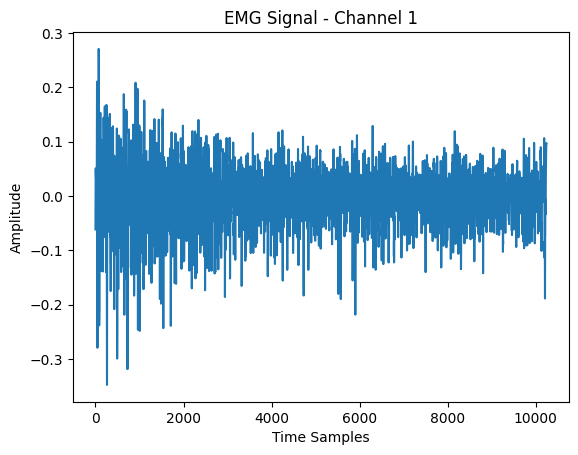

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(record.p_signal[:, 0])
plt.title("EMG Signal - Channel 1")
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.show()


## Preprocessing & Windowing

Raw EMG signals are long and non-stationary.
To make them suitable for machine learning, we divide the signal into fixed-length windows.

Window size: 200 samples

Step size: 200 samples (non-overlapping)

Each window represents a short muscle activity segment.


In [ ]:
import numpy as np

signal = record.p_signal #shape (10240,32)

window_size = 200
num_samples = signal.shape[0]   #10240

windows = []

for start in range(0, num_samples - window_size, window_size):  
    window = signal[start:start + window_size, :]
    windows.append(window)

windows = np.array(windows)


In [ ]:
print("Windows shape:", windows.shape)  #51 windows , each window = 200 time samples , 32 emg channels

Windows shape: (51, 200, 32)


In [20]:
windows

array([[[-6.15321436e-02, -6.05105048e-02, -7.12050324e-02, ...,
          1.91324042e-02,  2.48906948e-02, -5.12172474e-03],
        [-8.15270236e-03, -1.01173987e-02, -1.48763293e-02, ...,
          2.16451854e-02,  3.72555716e-02, -3.87079383e-03],
        [ 1.62959687e-02,  1.12630972e-02,  1.41530387e-02, ...,
          2.57890702e-02,  4.23597044e-02, -1.44879135e-03],
        ...,
        [-1.57298088e-02, -6.98876061e-03,  1.40357483e-02, ...,
          3.37682526e-02,  6.40085851e-02, -8.21359209e-03],
        [-2.96384700e-02, -2.18475883e-02, -5.44422828e-03, ...,
          1.54230605e-02,  5.12114664e-02, -7.03477296e-03],
        [-4.67836786e-02, -3.98614934e-02, -1.98416219e-02, ...,
         -8.75379915e-04,  3.41149204e-02, -1.08447783e-02]],

       [[-6.13906036e-02, -6.37889650e-02, -3.77675010e-02, ...,
         -1.29795540e-02,  2.05498827e-02, -1.65785593e-02],
        [-6.75523104e-02, -7.93616510e-02, -5.47550571e-02, ...,
         -1.23875705e-02,  1.93083368e

## Feature Extraction

Instead of using raw EMG values, we extract time-domain features from each window:

RMS (Root Mean Square): muscle contraction strength

MAV (Mean Absolute Value): signal intensity

Waveform Length: signal complexity

Zero Crossings: muscle activation frequency

There are 128 features per channel. Each row in the feature matrix represents one window


In [15]:
import numpy as np

def rms(window):
    return np.sqrt(np.mean(window**2, axis=0))

def mav(window):
    return np.mean(np.abs(window), axis=0)

def waveform_length(window):
    return np.sum(np.abs(np.diff(window, axis=0)), axis=0)

def zero_crossings(window, threshold=0.01):
    zc = []
    for ch in range(window.shape[1]):
        signal = window[:, ch]
        count = 0
        for i in range(1, len(signal)):
            if ((signal[i-1] > 0 and signal[i] < 0) or 
                (signal[i-1] < 0 and signal[i] > 0)):
                if abs(signal[i] - signal[i-1]) >= threshold:
                    count += 1
        zc.append(count)
    return np.array(zc)


In [16]:
features = []

for w in windows:
    feature_vector = np.concatenate([
        rms(w),
        mav(w),
        waveform_length(w),
        zero_crossings(w)
    ])
    features.append(feature_vector)

features = np.array(features)

print("Final feature matrix shape:", features.shape)


Final feature matrix shape: (51, 128)


In [19]:
features

array([[ 0.10127876,  0.09188076,  0.08681461, ..., 19.        ,
        19.        ,  1.        ],
       [ 0.09591721,  0.09265856,  0.09514797, ..., 25.        ,
        26.        ,  1.        ],
       [ 0.07784523,  0.07679384,  0.08697082, ..., 23.        ,
        20.        ,  0.        ],
       ...,
       [ 0.03939293,  0.04174764,  0.04908477, ..., 15.        ,
        12.        ,  2.        ],
       [ 0.04110935,  0.04638012,  0.05542719, ..., 14.        ,
        12.        ,  0.        ],
       [ 0.0435519 ,  0.04718487,  0.05526151, ..., 12.        ,
        12.        ,  1.        ]], shape=(51, 128))

## Labeling

Each EMG window is assigned a gesture label based on the file name.

Gesture labels are encoded as integers (0–16).

All windows from the same trial share the same gesture label.

In [21]:
gesture_map = {
    "gesture1": 0,
    "gesture2": 1,
    "gesture3": 2,
    "gesture4": 3,
    "gesture5": 4,
    "gesture6": 5,
    "gesture7": 6,
    "gesture8": 7,
    "gesture9": 8,
    "gesture10": 9,
    "gesture11": 10,
    "gesture12": 11,
    "gesture13": 12,
    "gesture14": 13,
    "gesture15": 14,
    "gesture16": 15,
    "gesture17": 16
}


In [31]:
#extracting gesture name from the file name

def get_gesture_label(filename,gesture_map):
    for g in gesture_map:
        if g in filename:
            return gesture_map[g]
        
    raise ValueError("Gesture not found in filename")

In [ ]:
#building record list

import os

base_path = '../data/grabmyo/Session1/session1_participant1'

record_list = []

for file in os.listdir(base_path):
    if file.endswith(".hea"):
        record_name = file.replace(".hea", "")
        record_path = os.path.join(base_path, record_name)
        record_list.append((record_path, record_name))

print("Total records found:", len(record_list))
        

Total records found: 119


In [ ]:
#windowing function

import numpy as np

def window_signal(signal, window_size=200, step_size=200):
    windows = []
    num_samples = signal.shape[0]

    for start in range(0, num_samples - window_size, step_size):
        window = signal[start:start + window_size, :]
        windows.append(window)

    return np.array(windows)


In [29]:
#feature functions 

def rms(window):
    return np.sqrt(np.mean(window**2, axis=0))

def mav(window):
    return np.mean(np.abs(window), axis=0)

def waveform_length(window):
    return np.sum(np.abs(np.diff(window, axis=0)), axis=0)

def zero_crossings(window, threshold=1e-3):
    return np.sum(
        (np.diff(np.sign(window), axis=0) != 0) &
        (np.abs(np.diff(window, axis=0)) > threshold),
        axis=0
    )


In [30]:
# feature extraction wrapper
def extract_features(windows):
    feature_list = []

    for w in windows:
        feature_vector = np.concatenate([
            rms(w),
            mav(w),
            waveform_length(w),
            zero_crossings(w)
        ])
        feature_list.append(feature_vector)

    return np.array(feature_list)


In [40]:
import wfdb

all_features = []
all_labels = []

for record_path, record_name in record_list:
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal

    windows = window_signal(signal)
    features = extract_features(windows)

    label = get_gesture_label(record_name, gesture_map)
    labels = np.full(len(features), label)

    all_features.append(features)
    all_labels.append(labels)

X = np.vstack(all_features)
y = np.concatenate(all_labels)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (6069, 128)
y shape: (6069,)


In [ ]:
X  #contains feature values extracted from each EMG window

array([[8.54852084e-02, 1.14878569e-01, 1.46935777e-01, ...,
        2.80000000e+01, 2.50000000e+01, 4.90000000e+01],
       [9.26000101e-02, 1.23069957e-01, 1.64249776e-01, ...,
        4.00000000e+01, 2.40000000e+01, 4.20000000e+01],
       [6.90466844e-02, 1.01273822e-01, 1.41089220e-01, ...,
        3.30000000e+01, 2.20000000e+01, 4.70000000e+01],
       ...,
       [2.25250280e-02, 2.77471620e-02, 3.31086004e-02, ...,
        2.90000000e+01, 2.70000000e+01, 7.00000000e+01],
       [2.30596841e-02, 3.36848305e-02, 3.90472880e-02, ...,
        3.90000000e+01, 3.60000000e+01, 5.70000000e+01],
       [2.26824274e-02, 2.69101022e-02, 2.87453229e-02, ...,
        1.80000000e+01, 2.40000000e+01, 5.70000000e+01]],
      shape=(6069, 128))

In [43]:
y #respresents the integer encoded gesture label associated with each window

array([0, 0, 0, ..., 8, 8, 8], shape=(6069,))

## Train-Test Split and Scaling
The dataset is split into training and testing sets to evaluate model generalization.

Feature scaling is applied using StandardScaler:

Mean = 0

Standard deviation = 1

Only training data is used to fit the scaler to avoid data leakage.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#1 train test split

X_train,X_test,y_train,y_test= train_test_split (X,y,test_size=0.2,random_state=42,stratify=y)

#2 scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [46]:
print(X_train_scaled)
print(X_test_scaled)

[[-0.12041295  0.55111321  0.70270192 ... -0.19010462 -1.16074548
   0.23128004]
 [-0.19703278 -0.34184072 -0.47590094 ...  2.88642175  2.67694575
   1.02482391]
 [-0.4783721  -0.63004088 -0.63730997 ...  0.13374026  0.06731571
  -0.56226383]
 ...
 [-0.39501503 -0.26833589 -0.13180195 ... -0.83779438 -0.23969959
   1.18353268]
 [-0.10977245 -0.35289317 -0.46599663 ... -1.3235617   0.06731571
   0.07257126]
 [-0.30714777  0.0887961   0.3525851  ... -0.19010462  0.83485396
   0.54869758]]
[[-0.64280583 -0.8008602  -0.78224678 ...  0.13374026 -0.39320723
   0.38998881]
 [-0.28966396 -0.44372062 -0.60653333 ... -0.19010462  1.9094075
   0.38998881]
 [-0.35640344 -0.49923723 -0.53324499 ...  0.94335247  0.22082336
  -1.51451648]
 ...
 [-0.94126662 -1.09183728 -1.07378937 ... -0.99971682 -0.23969959
  -1.51451648]
 [ 1.07431729  0.73365661  0.49080448 ...  0.94335247 -0.39320723
  -0.87968138]
 [-0.5615828  -0.62183524 -0.43635954 ...  1.91488711  3.29097635
  -0.72097261]]


## Exploratory Data Analysis (EDA)

Before training the machine learning model, exploratory data analysis was performed to better understand the characteristics of the extracted EMG features. Visualizing feature distributions helps verify correct feature extraction, scaling, and variability across EMG windows.


### Feature Distribution Visualization

The histogram above shows the distribution of the Root Mean Square (RMS) feature extracted from the first EMG channel across all training windows. RMS represents the muscle activation intensity within a window.

After standardization, the feature values are centered around zero with unit variance, indicating successful feature scaling. Such visualizations help ensure that no feature dominates the learning process due to scale differences.


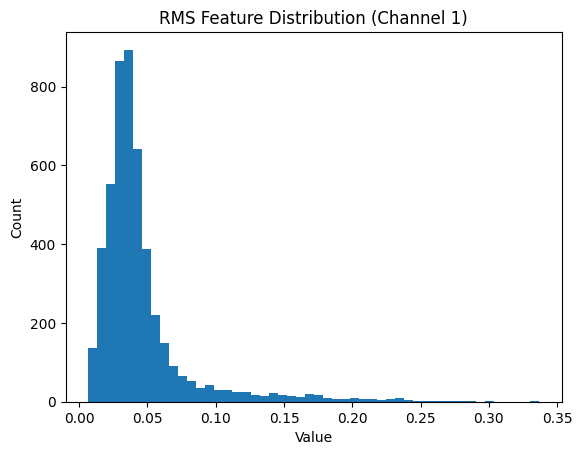

In [47]:
import matplotlib.pyplot as plt

plt.hist(X_train[:, 0], bins=50)
plt.title("RMS Feature Distribution (Channel 1)")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


### Effect of Feature Scaling

The left plot shows the distribution of the RMS feature before scaling, while the right plot shows the same feature after standardization. Feature scaling ensures that all extracted EMG features contribute equally during model training and prevents features with larger numeric ranges from dominating the classifier.


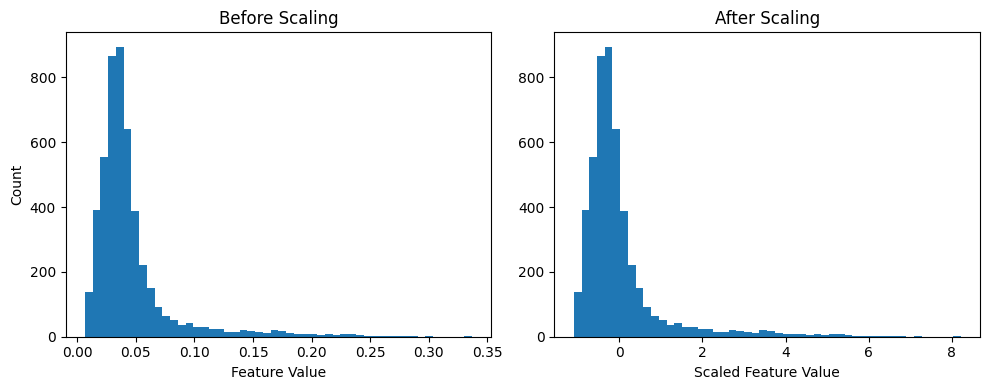

In [48]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(X_train[:, 0], bins=50)
plt.title("Before Scaling")
plt.xlabel("Feature Value")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(X_train_scaled[:, 0], bins=50)
plt.title("After Scaling")
plt.xlabel("Scaled Feature Value")

plt.tight_layout()
plt.show()


### Gesture Class Distribution

The bar chart above illustrates the distribution of EMG windows across different gesture classes in the training dataset. A relatively balanced class distribution ensures that the classifier does not become biased toward any specific gesture during training.


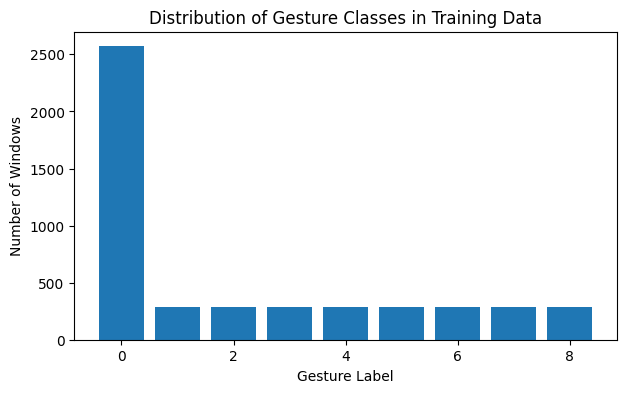

In [50]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(7,4))
plt.bar(unique, counts)
plt.xlabel("Gesture Label")
plt.ylabel("Number of Windows")
plt.title("Distribution of Gesture Classes in Training Data")
plt.show()


## Model Training 
Two models are trained. 



## SVM Classifier 
A Support Vector Machine (SVM) classifier was used as the primary model for EMG-based hand gesture recognition. SVMs are supervised learning models that aim to find an optimal hyperplane that maximizes the margin between different gesture classes in the feature space.

Test Accuracy: 94.15%

In [52]:
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale'
)

svm_model.fit(X_train_scaled, y_train)


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",10
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [53]:
y_pred = svm_model.predict(X_test_scaled)


In [54]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.9415156507413509


## Confusion matrix
The confusion matrix shows that most gesture classes are classified correctly, with strong diagonal dominance indicating high true positive rates. Minor misclassifications occur primarily between gestures with similar muscle activation patterns, which is expected in EMG-based recognition tasks.

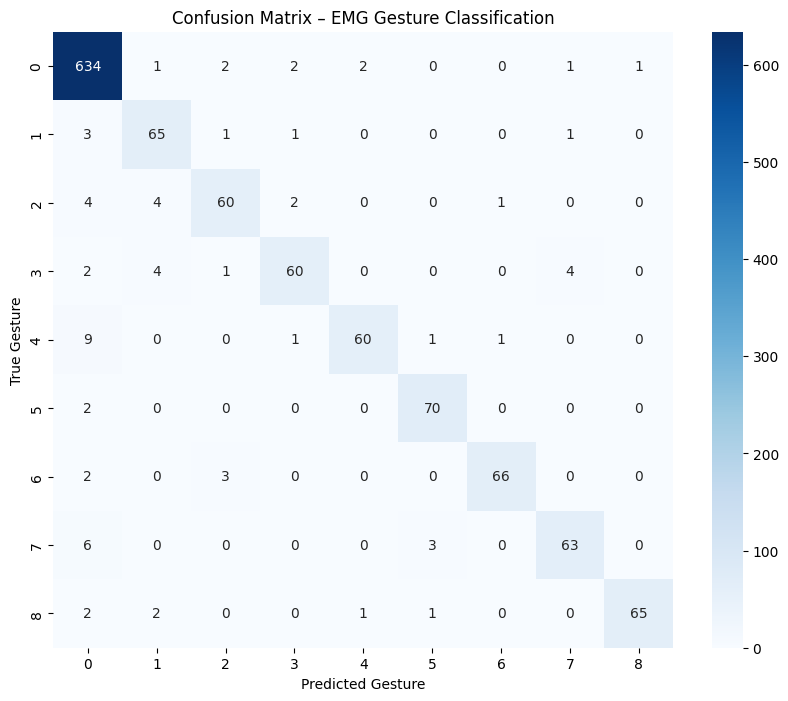

In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Gesture")
plt.ylabel("True Gesture")
plt.title("Confusion Matrix – EMG Gesture Classification")
plt.show()


In [ ]:
cm  #confusion matrix

array([[634,   1,   2,   2,   2,   0,   0,   1,   1],
       [  3,  65,   1,   1,   0,   0,   0,   1,   0],
       [  4,   4,  60,   2,   0,   0,   1,   0,   0],
       [  2,   4,   1,  60,   0,   0,   0,   4,   0],
       [  9,   0,   0,   1,  60,   1,   1,   0,   0],
       [  2,   0,   0,   0,   0,  70,   0,   0,   0],
       [  2,   0,   3,   0,   0,   0,  66,   0,   0],
       [  6,   0,   0,   0,   0,   3,   0,  63,   0],
       [  2,   2,   0,   0,   1,   1,   0,   0,  65]])

In [58]:
np.unique(y_test)


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [61]:
#model evaluation 
from sklearn.metrics import classification_report   

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       643
           1       0.86      0.92      0.88        71
           2       0.90      0.85      0.87        71
           3       0.91      0.85      0.88        71
           4       0.95      0.83      0.89        72
           5       0.93      0.97      0.95        72
           6       0.97      0.93      0.95        71
           7       0.91      0.88      0.89        72
           8       0.98      0.92      0.95        71

    accuracy                           0.94      1214
   macro avg       0.93      0.90      0.91      1214
weighted avg       0.94      0.94      0.94      1214



## Principal Component Analysis (PCA) of EMG Features

After extracting time-domain features (RMS, MAV, Waveform Length, and Zero Crossings) from the EMG signals, the resulting feature vectors are 128-dimensional.
To better understand the structure of this high-dimensional feature space, Principal Component Analysis (PCA) was applied for visualization.

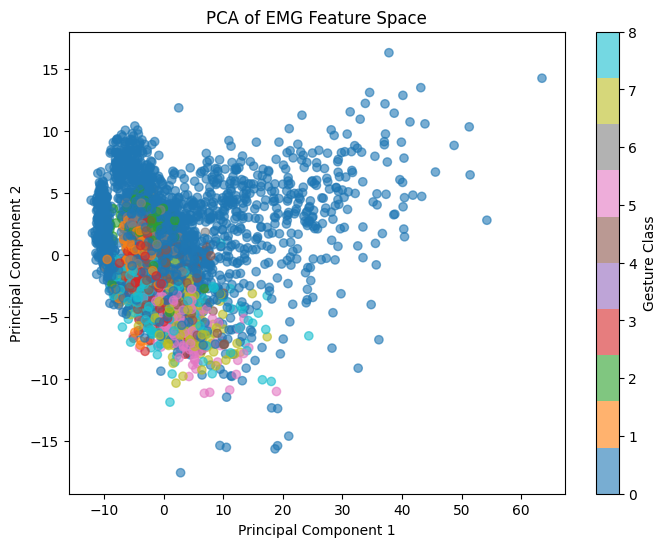

In [63]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y_train,
    cmap='tab10',
    alpha=0.6
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of EMG Feature Space")
plt.colorbar(scatter, label="Gesture Class")
plt.show()


## Random Forest Classifier


A Random Forest classifier was trained as a baseline ensemble learning method. Random Forests operate by constructing multiple decision trees during training and aggregating their predictions, which helps reduce overfitting and improve generalization compared to a single decision tree.

Test Accuracy: 91.35%

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled)

from sklearn.metrics import accuracy_score
print("RF Accuracy:", accuracy_score(y_test, rf_preds))


RF Accuracy: 0.913509060955519


The Random Forest classifier achieved strong performance, correctly classifying the majority of EMG windows across gesture classes. However, its accuracy was slightly lower than that of the Support Vector Machine (SVM), suggesting that the EMG feature space is more effectively separated by a margin-based decision boundary rather than tree-based splits.

## Cross-Validation (SVM)


Cross-validation was employed to evaluate the robustness and generalization capability of the SVM classifier. Rather than relying on a single train–test split, cross-validation assesses model performance across multiple data partitions.

Technique: k-fold cross-validation

Number of folds: 5

The dataset was split into five equal folds.

In each iteration, four folds were used for training and one fold for validation.

The process was repeated five times, with each fold serving as the validation set once

In [65]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    svm_model,
    X_train_scaled,
    y_train,
    cv=5
)

print("CV Accuracy:", scores.mean(), "+/-", scores.std())


CV Accuracy: 0.9326467559217301 +/- 0.0028836251287332804


Mean Cross-Validation Accuracy: 93.26%

Standard Deviation: ± 0.29%

The high mean accuracy indicates that the SVM consistently performs well across different subsets of the data. The very low standard deviation demonstrates that the model’s performance is stable and not sensitive to how the data is split.

## Conclusion

In this project, EMG signals were processed and classified to recognize different hand gestures. The raw signals were divided into windows, and meaningful time-domain features (RMS, MAV, WL, and ZC) were extracted from each window. These features were then used to train machine learning models.

Among the tested models, the Support Vector Machine (SVM) achieved the highest accuracy, showing strong performance in distinguishing between different gestures. PCA was used to visualize feature separability and better understand the data distribution. Overall, the results demonstrate that EMG-based gesture recognition using traditional feature extraction and machine learning is accurate and effective.

## Future Work

Deep learning models (CNN/LSTM) on raw EMG

Subject-independent evaluation

Real-time gesture recognition

Feature selection and optimization